In [2]:
import os
import cv2
import time
import imutils
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm#_notebook as tqdm


In [3]:
def rotate_bound(image, angle, borderValue):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH), borderValue=(borderValue,borderValue,borderValue))

In [6]:
y_filter = np.ones((9,9))
y_filter[:4] = -1
y_filter[4] = 0

def sobel(img, dx, dy, ksize):
    sobelx64f = cv2.Sobel(img,cv2.CV_64F,dx,dy,ksize=ksize)
    abs_sobel64f = np.absolute(sobelx64f)
    return np.uint8(abs_sobel64f)

def get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold):
    consecutive = 0 
    consecutive_coords = []
    text_coords = []
    for j in range(height//squ_size):
        sy = j*squ_size
        ey = j*squ_size + squ_size
        for i in range(width//squ_size):
            sx = i*squ_size
            ex = i*squ_size + squ_size

            squ = sobel_xy[sy:ey,sx:ex,:]

            _mean = squ.mean()
            if _mean >= threshold:
                consecutive += 1
                consecutive_coords += [(sx,sy,ex,ey)]

            elif consecutive >= 0:
                if consecutive >= min_consecutive:
                    consecutive = 0
                    text_coords += consecutive_coords
                else:
                    consecutive = 0
                    consecutive_coords = []

        if consecutive >= min_consecutive:
            text_coords += consecutive_coords
        consecutive_coords = []
        consecutive = 0
    
    return text_coords

def plot_rectangles(img, rectangles, colors=False):
    if not colors:
        messy = img.copy()
        for (startX, startY, endX, endY) in rectangles:
            cv2.rectangle(messy, (startX, startY), (endX, endY), (0, 255, 0), 2)
    
    if colors:
        colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255),(255,255,255),(100,100,100)]
        messy = img.copy()
        color = 0
        for label in rectangles:
            for (startX, startY, endX, endY) in label:
                cv2.rectangle(messy, (startX, startY), (endX, endY), colors[color], 2)
            color += 1
            if color == len(colors):
                color = 0
    plt.figure()
    plt.imshow(messy)
    
def group_squares_into_labels(coords, max_dist_btw, min_squ_per_label):
    coords_stack = coords.copy()

    labels = []
    while len(coords_stack):
        squ1 = coords_stack[0]
        sx1, sy1, ex1, ey1 = squ1
        mx1 = (sx1+ex1)/2
        my1 = (sy1+ey1)/2

        new_label = []
        to_be_checked = [squ1]
        coords_stack.remove(squ1)

        while len(to_be_checked):
            squ1 = to_be_checked[0]
            sx1, sy1, ex1, ey1 = squ1
            mx1 = (sx1+ex1)/2
            my1 = (sy1+ey1)/2

            new_label += [squ1]
            to_be_checked.remove(squ1)

            coords_stack2 = coords_stack.copy()
            for i in range(len(coords_stack2)):
                squ2 = coords_stack2[i]
                sx2, sy2, ex2, ey2 = squ2
                mx2 = (sx2+ex2)/2
                my2 = (sy2+ey2)/2
                dist = np.sqrt((mx1-mx2)**2 + (my1-my2)**2)
                if dist <= max_dist_btw:
                    to_be_checked += [squ2]
                    coords_stack.remove(squ2)
        if len(new_label) >= min_squ_per_label:
            labels += [new_label]
            
    return labels

  0%|          | 0/9070 [00:00<?, ?it/s]


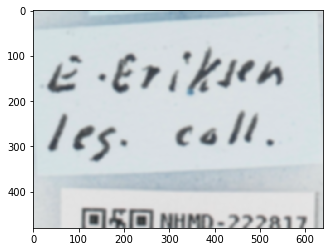

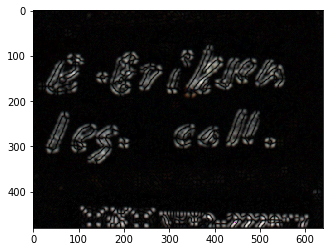

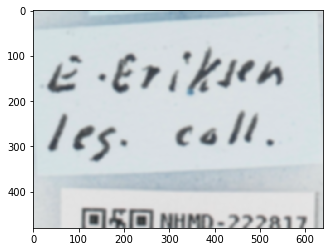

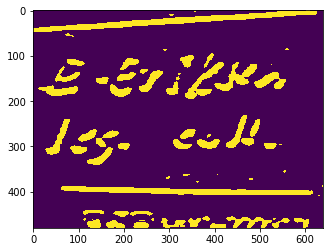

In [7]:

debug = True

folderGlob = '/home/rob/HWR/datasets/zooniverse/**/Cropped00[2,4].jpg'
fps = glob(folderGlob)
if debug == True:
    fps = np.random.permutation(fps)
    
for fp in tqdm(fps):
    new_img_size = (480, 640)
    squ_size = 7
    assert squ_size%2 == 1
    max_dist_btw = squ_size*2.4
    min_consecutive = 3
    min_squ_per_label = 40
    threshold = 10
    height, width = new_img_size

    orig = cv2.imread(fp)
    orig_size = orig.shape[:2]
    scale = np.array(orig_size) / np.array(new_img_size)
    img = cv2.resize(orig, (width, height))
    
    img = cv2.GaussianBlur(img, (11,11), 3)
    sobel_xy = sobel(img, 1, 1, 5)    
    
    if debug == True:
        plt.imshow(img)
        plt.figure()
        plt.imshow(sobel_xy)

    text_coords = get_consecutive_coords_above_threshold(sobel_xy, height, width, squ_size, threshold)
    if debug == True:
        plot_rectangles(sobel_xy, text_coords)

    labels = group_squares_into_labels(text_coords, max_dist_btw, min_squ_per_label)
    if debug == True:
        plot_rectangles(img, labels, colors=True)
    
    sobel_y = sobel(img, 0, 1, 3)
    sobel_y = cv2.filter2D(img, -1, y_filter)
    sobel_y = cv2.cvtColor(sobel_y, cv2.COLOR_BGR2GRAY)
    _,sobel_y = cv2.threshold(sobel_y,120,255,cv2.THRESH_BINARY)

    
    #sobel_y = sobel_y / 255
    max_angle = 45
    n_angles = 300
    pad = 5
    
    
    if debug == True:
        plt.figure()
        plt.imshow(img)
        plt.figure()
        plt.imshow(sobel_y)
    i = 0
    for label in labels:
        label = np.array(label)
        sx = max(label.min(axis=0)[0]-pad,0)
        sy = max(label.min(axis=0)[1]-pad,0)
        ex = min(label.max(axis=0)[2]+pad,width)
        ey = min(label.max(axis=0)[3]+pad,height)
        
        label_img = sobel_y[sy:ey,sx:ex].copy()
        
        messy = cv2.cvtColor(label_img, cv2.COLOR_GRAY2BGR).copy()
        thetas = []
        thres = 150
        min_len = 80
        max_gap = 20
        lines = cv2.HoughLinesP(label_img,1,np.pi/180,thres,300,min_len, max_gap)
        while (thres > 0) & (lines is None) & (min_len > 0):
            min_len -= 10
            thres -= 10
            max_gap += 10
            lines = cv2.HoughLinesP(label_img,1,np.pi/180,thres,300,min_len, max_gap)
            
        if lines is None:
            lines = []
        
        for line in lines:
            x1,y1,x2,y2 = line[0]
            cv2.line(messy,(x1,y1),(x2,y2),(0,255,0),2)
            thetas += [np.arctan((y2-y1)/(x2-x1))]
        
        if len(lines):
            best_angle = np.mean(thetas)*180/np.pi
        else:
            best_angle = 0
        
        if debug == True:
            plt.figure()
            plt.imshow(messy)
            plt.title(best_angle)    

        if debug == True:
            sx = int(scale[1]*(sx))
            sy = int(scale[0]*(sy))
            ex = int(scale[1]*(ex))
            ey = int(scale[0]*(ey))
            dst = rotate_bound(orig[sy:ey,sx:ex].copy(), best_angle, borderValue=255)
            plt.figure()
            plt.imshow(dst)
            plt.title(str(best_angle))


        M = cv2.getRotationMatrix2D((0, 0), best_angle, 1.0)
        rotated_squs = [np.append(a[:2],[1]) for a in label]
        rotated_squs += [np.append(a[2:],[1]) for a in label]
        rotated_squs = np.dot(rotated_squs, M.T)
        sx = rotated_squs.min(axis=0)[0]
        sy = rotated_squs.min(axis=0)[1]
        ex = rotated_squs.max(axis=0)[0]
        ey = rotated_squs.max(axis=0)[1]
        
        sx = int(scale[1]*(sx))
        sy = int(scale[0]*(sy))
        ex = int(scale[1]*(ex))
        ey = int(scale[0]*(ey))
        

        x_offset = 0
        y_offset = 0
        if best_angle < 0:
            x_offset = np.abs((orig.shape[0])*np.sin(best_angle*np.pi/180))
        elif best_angle > 0: 
            y_offset = np.abs((orig.shape[1])*np.sin(best_angle*np.pi/180))

        
            
        nsx = int(sx + x_offset - pad)
        nsy = int(sy + y_offset - pad)
        nex = int(ex + x_offset + pad)
        ney = int(ey + y_offset + pad)
        nsx = max(nsx, 0)
        nsy = max(nsy, 0)
        nex = min(nex, orig.shape[1])
        ney = min(ney, orig.shape[0])
        
        aspect_ratio = (nex-nsx)/(ney-nsy)
        if aspect_ratio > 10:
            print('AR too large')
            continue
        
        dst = rotate_bound(orig, best_angle, borderValue=255)
        
        if debug == True:
            plt.figure()
            plt.imshow(dst[nsy:ney,nsx:nex])
            
        if debug == False:
            new_fp = fp.replace('Cropped','Label').replace('.jpg','%s.jpg'%i)
            cv2.imwrite(new_fp, dst[nsy:ney,nsx:nex])

        i+=1
    if debug == True:
        break
